<img src="https://media.hearstapps.com/hmg-prod/images/best-movies-1614634680.jpg?crop=1920,960,x0,y0,safe&width=768&auto=webp&optimize=small" width="400" style="float:right">

# 3. Movie Ratings

For this project we'll do some data loading, wrangling and plot some data from movie ratings.  GroupLens research https://grouplens.org/ has provided data sets on movie ratings from the web site https://movielens.org/

The data contains how users rated movies, movie title and meta data (genre and year) and info about the users that rated the movies.


In this project, we'll do some analysis of this data to find out what some of the most popular movies are overall and the differences in opinions overall and between men and women.

In [1]:
%matplotlib inline
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
print("Setup Complete")

Setup Complete


# Accessing and examining data

Once we have access to our data, lets have a look at the raw data format so we can figure out how to load it for analysis.

The following code *clones* the github repository containing our data to our local runtime in the cloud.  If the directory datasets is already there, you don't need to run this again and can disable it or comment out the lines.

In [2]:
# !git clone https://github.com/mblackstock/datasets.git

In [3]:
!head -n 10 datasets/movies/ml-1m/users.dat

1::F::1::10::48067
2::M::56::16::70072
3::M::25::15::55117
4::M::45::7::02460
5::M::25::20::55455
6::F::50::9::55117
7::M::35::1::06810
8::M::25::12::11413
9::M::25::17::61614
10::F::35::1::95370


We can see this file quite different from the CSV file we used in the previous project.  It is organized in a table with no row or column headings.  Columns are separated using colons (::).

Fortunately we can use the README information supplied with the data to know what the data in each column represents.  The columns are as follows:

- user id
- gender
- age
- occupation code
- zip code

Using this information we can get an understanding of the person who rated movies.

In [4]:
!head -n 10 datasets/movies/ml-1m/ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


This file contains the following columns:

- user id
- movie id
- rating (1-5)
- unix timestamp in seconds

In [5]:
!head -n 10 datasets/movies/ml-1m/movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


This file contains:

- movie id
- movie title
- list of genres

It looks like we have a lot of interesting data.  Next, lets load up the data and use it for some analysis!

# Loading Data

To load the data into a DataFrame for analysis we can't use `read_csv` since it is not a csv file.  Instead we use `read_table` as shown.

In [7]:
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('datasets/movies/ml-1m/users.dat',sep='::', header=None, names=unames, engine="python")

rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('datasets/movies/ml-1m/ratings.dat',sep='::', header=None, names=rnames,engine="python")

mnames = ['movie_id', 'title', 'genre']
movies = pd.read_table('datasets/movies/ml-1m/movies.dat',sep='::', header=None, names=mnames,engine="python")


Now that their loaded, let's look at the DataFrames we've loaded.

In [8]:
users[:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Another way to do this is using the head method:

In [9]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
ratings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
movies[:5]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Merging Datasets

We'd like to answer questions that span all three tables, for example, to understand what the most highly rated movies are on average, and how ratings differ between men and women.

To allow us to do analysis, we can merge all of the tables into one big table.  To do this we'll use the `merge` method that connects rows in DataFrames based on one or more keys.  If you're familiar with databases, this is similar to how a database does *join* operations.

Here's how the merge function works.  First lets set up some simple DataFrames for an example:

In [11]:
df1 = pd.DataFrame({'key': ['b','b','a','c','a','a','b'], 'data1':range(7)})
df2 = pd.DataFrame({'key': ['a','b','d'], 'data2':range(3)})
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [12]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


now lets merget to see what happens!

In [13]:
pd.merge(df1,df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


How does this work?  It merged the two tables using the columns with the same name (key).  It only included the keys that are common in both tables.  This means it is in 'inner' join. You can also specify outer, left or right join where the keys are a union of both, only the left, or only the right.

It's a good idea to specify the key, so we can do the following

In [14]:
pd.merge(df1,df2,on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


If the keys aren't the same, we can specify them on each table like this.

In [15]:
df3 = pd.DataFrame({'lkey': ['b','b','a','c','a','a','b'], 'data3':range(7)})
df4 = pd.DataFrame({'rkey': ['a','b','d'], 'data4':range(3)})
pd.merge(df3, df4, left_on="lkey", right_on='rkey')

,lkey,data3,rkey,data4
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


So, lets use merge to merge the ratings and user tables together first.

In [16]:
ratings_users = pd.merge(ratings, users)
ratings_users

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip
0,1,1193,5,978300760,F,1,10,48067
1,1,661,3,978302109,F,1,10,48067
2,1,914,3,978301968,F,1,10,48067
3,1,3408,4,978300275,F,1,10,48067
4,1,2355,5,978824291,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106
1000205,6040,1094,5,956704887,M,25,6,11106
1000206,6040,562,5,956704746,M,25,6,11106
1000207,6040,1096,4,956715648,M,25,6,11106


Now we have the user information from the users table along with each user's rating from the ratings table.

Next we'll merge this table with the movies table.  The most important data is the ratings so that goes first.

In [17]:
data = pd.merge(ratings_users, movies)
data

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genre
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,M,18,17,47901,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy|Drama|Western


Looks like all the info we need is there now in one large table!  Lets get info on the table.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1000209 non-null  int64 
 1   movie_id    1000209 non-null  int64 
 2   rating      1000209 non-null  int64 
 3   timestamp   1000209 non-null  int64 
 4   gender      1000209 non-null  object
 5   age         1000209 non-null  int64 
 6   occupation  1000209 non-null  int64 
 7   zip         1000209 non-null  object
 8   title       1000209 non-null  object
 9   genre       1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 83.9+ MB


# Data aggregation and grouping

Lets look at how we can calculate the average rating for each movie.  Currently our data is a long list of user ratings.  What we want is a table where the key is the title of the movie, and the data is the average rating.  How would we do this?

## Groupby method

What we want to do is calculate aggregate statistics on different *groups* of data.

One way to do this is using the `groupby` method on the dataset that splits a DataFrame or Series into pieces by one or more keys.

Then we can apply some summary statistics like count, mean, or standard deviation or some user-defined function on the pieces (groups).

It works as illustrated below.

![Group by](https://raw.githubusercontent.com/mblackstock/ds1-analytics/main/images/groupby.jpg)

The data table is *split* into groups with each group having the remaining columns.  We then *apply* an aggregate function to each group, and then combine them back together. 

So, for example, to calculate the average rating of each movie we can do this:

In [19]:
data.groupby('title')['rating'].mean()

title
$1,000,000 Duck (1971)                        3.027027
'Night Mother (1986)                          3.371429
'Til There Was You (1997)                     2.692308
'burbs, The (1989)                            2.910891
...And Justice for All (1979)                 3.713568
                                                ...   
Zed & Two Noughts, A (1985)                   3.413793
Zero Effect (1998)                            3.750831
Zero Kelvin (Kj�rlighetens kj�tere) (1995)    3.500000
Zeus and Roxanne (1997)                       2.521739
eXistenZ (1999)                               3.256098
Name: rating, Length: 3706, dtype: float64

What this does is split the data into groups that have the same title, then get only the 'rating' column of those groups, then calculate the average for each group.  If we left out the rating it would provide the average for every column.

Lets get the average for male and female.

In [20]:
average_ratings_mf = data.groupby(['title','gender'])['rating'].mean()
average_ratings_mf

title                                       gender
$1,000,000 Duck (1971)                      F         3.375000
                                            M         2.761905
'Night Mother (1986)                        F         3.388889
                                            M         3.352941
'Til There Was You (1997)                   F         2.675676
                                                        ...   
Zero Kelvin (Kj�rlighetens kj�tere) (1995)  M         3.500000
Zeus and Roxanne (1997)                     F         2.777778
                                            M         2.357143
eXistenZ (1999)                             F         3.098592
                                            M         3.289086
Name: rating, Length: 7152, dtype: float64

This gives us a series with what is called a *hierarchical index* (title, gender).  We can use a method called reset_index to reset the index to the default range so the index goes back into columns.

In [21]:
average_ratings_mf = average_ratings_mf.reset_index()
average_ratings_mf

,title,gender,rating
0,"$1,000,000 Duck (1971)",F,3.375000
1,"$1,000,000 Duck (1971)",M,2.761905
2,'Night Mother (1986),F,3.388889
3,'Night Mother (1986),M,3.352941
4,'Til There Was You (1997),F,2.675676
...,...,...,...
7147,Zero Kelvin (Kj�rlighetens kj�tere) (1995),M,3.500000
7148,Zeus and Roxanne (1997),F,2.777778
7149,Zeus and Roxanne (1997),M,2.357143
7150,eXistenZ (1999),F,3.098592


Now, lets move data that's in the gender rows into columns using `pivot`.

In [22]:
average_ratings_mf.pivot(index='title', columns='gender')

rating          
gender                                             F         M
title                                                         
$1,000,000 Duck (1971)                      3.375000  2.761905
'Night Mother (1986)                        3.388889  3.352941
'Til There Was You (1997)                   2.675676  2.733333
'burbs, The (1989)                          2.793478  2.962085
...And Justice for All (1979)               3.828571  3.689024
...                                              ...       ...
Zed & Two Noughts, A (1985)                 3.500000  3.380952
Zero Effect (1998)                          3.864407  3.723140
Zero Kelvin (Kj�rlighetens kj�tere) (1995)       NaN  3.500000
Zeus and Roxanne (1997)                     2.777778  2.357143
eXistenZ (1999)                             3.098592  3.289086

[3706 rows x 2 columns]



## Pivot Table

Another way to do this is with the `pivot_table` method. A pivot table is a data summarization tool frequently found in spreadsheet applications like excel.  It aggregates a table of data by one ore more keys, arranging the data in a rectable with some of the group keys along the rows, and others along the columns.   
For example, to accomplish the same thing as our `groupby` method above we can do the following:

In [23]:
data.pivot_table('rating', index='title')

,rating
title,
"$1,000,000 Duck (1971)",3.027027
'Night Mother (1986),3.371429
'Til There Was You (1997),2.692308
"'burbs, The (1989)",2.910891
...And Justice for All (1979),3.713568
...,...
"Zed & Two Noughts, A (1985)",3.413793
Zero Effect (1998),3.750831
Zero Kelvin (Kj�rlighetens kj�tere) (1995),3.500000


Pivot and pivot_table are very similar.  Most of the time we'll use pivot_table.


* pivot_table is a generalization of pivot that can handle duplicate values for one pivoted index/column pair. Specifically, you can give pivot_table a list of aggregation functions using keyword argument aggfunc. The default aggfunc of pivot_table is numpy.mean.
* pivot_table also supports using multiple columns for the index and column of the pivoted table. A hierarchical index will be automatically generated for you.

With pivot_table we can also group the aggregation using values in other columns in one go.  For example to get ratings by gender we can do the following:

In [24]:
data.pivot_table('rating', index='title', columns='gender', aggfunc='mean', margins=True)

gender,F,M,All
title,,,
"$1,000,000 Duck (1971)",3.375000,2.761905,3.027027
'Night Mother (1986),3.388889,3.352941,3.371429
'Til There Was You (1997),2.675676,2.733333,2.692308
"'burbs, The (1989)",2.793478,2.962085,2.910891
...And Justice for All (1979),3.828571,3.689024,3.713568
...,...,...,...
Zero Effect (1998),3.864407,3.723140,3.750831
Zero Kelvin (Kj�rlighetens kj�tere) (1995),NaN,3.500000,3.500000
Zeus and Roxanne (1997),2.777778,2.357143,2.521739


Note that we specify the aggregate function explicity here - by default the aggregation used is `mean`.  We also specify columns that we want to group the ratings by.  Another feature of pivot table is that we can set `margins=True` to include an `All` column that is the aggregate of all of the members of the column group.  Nice!

Lets keep just the gender averages and drop the margins.


In [25]:
mean_ratings = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')
mean_ratings.head(5)

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


# Data Filtering

Let's focus only on movies that have been watched and rates more than few times.

How can we do that?

First, lets get the number of times each movie has been rated.  We can do that using `groupby`.

In [38]:
ratings_by_title = data.groupby('title').size()
ratings_by_title[:5]

title
$1,000,000 Duck (1971)            37
'Night Mother (1986)              70
'Til There Was You (1997)         52
'burbs, The (1989)               303
...And Justice for All (1979)    199
dtype: int64

We're grouping by title and then getting the size of each group.  This doesn't look like a table though.  It's actually a Series.  Pandas will return a Series when there is only one column.

Now, lets get the title (index) of the ratings_by_title series where the number of ratings is greater than or equal to some reasonable number, say 250 ratings.

In [27]:
active_titles = ratings_by_title.index[ratings_by_title >=250]
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

Now we select only the rows that are in the active titles list to keep only the movies that have been rated many times.

In [28]:
mean_ratings = mean_ratings.loc[active_titles]
mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
...,...,...
Young Guns (1988),3.371795,3.425620
Young Guns II (1990),2.934783,2.904025
Young Sherlock Holmes (1985),3.514706,3.363344


# Sorting data

Now that we have the ratings for active movies for both men and women, lets sort them.

In [29]:
top_movies = mean_ratings.sort_values(by='F',ascending=False)
top_movies[:10]


gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


We can plot the top 10 movies ad rated by females.

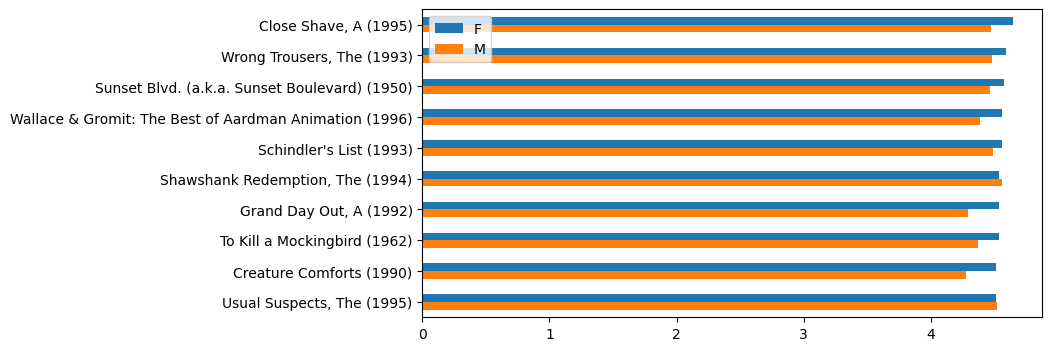

In [30]:
top_movies[:10].plot.barh(figsize=(8,4),xlabel='').invert_yaxis()
plt.legend(loc="upper left")

Can you improve on this simple visualization?  

# Adding new columns

Lets add a new column called `diff` to the data that contains the difference between the average ratings for men and women to understand differences in movie ratings based on gender, and variation on the ratings.

We'll then sort by this difference to get the movies where the difference between men and women's ratings were the greatest on average.

In [31]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:10]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


We can use the Python slice syntax to reverse the order of the rows, and then slice off the top 10 to get the movies that men liked a lot more than women.

Note the syntax for slice - we want all of the elements but step through them in reverse order (-1)

In [32]:
sorted_by_diff[::-1][:10]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


This seems to make sense!

Lets look a the movies that had the most disagreement between individual ratings indepedent of gender.  This means that the *standard deviation*, or the measure of the difference between individual measurements and the mean is the largest.  This might help us find the most 'controversial' movies.

In [33]:
rating_std_by_title = data.groupby('title')['rating'].std()
# filter to only the active titles again
rating_std_by_title = rating_std_by_title.loc[active_titles]
# sort descending and then show the top 10
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

It's interesting that Dumb and Dumber has a big difference rating, but not that surprising if you have seen the movie!

How would you visualize this data?

# Next

You will have noticed that the movie genres have been split using the `|` character.  With more processing we can analyse the movie data by genre - i.e. what genres of movies do men and women prefer.  How would we do this processing?  How would we visualize this data?

Check out this stack exchange question for a big hint:

https://datascience.stackexchange.com/questions/14847/multiple-categorical-values-for-a-single-feature-how-to-convert-them-to-binary-u

* What are some of the other questions we can ask?
  * What are the favourite genres of men vs women?  How would you determine that?

* Ratings also include a time stamp.  How would you graph the number of ratings over a period of time?  What would this tell us?



## Cleaning by splitting strings

TODO: Complete this section on cleaning for analysis by genre.

Strategy is to split column, expanding into columns - one for each genre, and then stack

What is stacking?



In [34]:
cleaned = movies.set_index('title').genre.str.split('|', expand=True).stack()
# movies.set_index('title').genre.str.split('|', expand=True).stack()[:10]


In [35]:
cleaned

title                        
Toy Story (1995)            0     Animation
                            1    Children's
                            2        Comedy
Jumanji (1995)              0     Adventure
                            1    Children's
                                    ...    
Requiem for a Dream (2000)  0         Drama
Tigerland (2000)            0         Drama
Two Family House (2000)     0         Drama
Contender, The (2000)       0         Drama
                            1      Thriller
Length: 6408, dtype: object

In [36]:
dummies = pd.get_dummies(cleaned) # what does this do?
dummies.groupby(level=0).apply(lambda x: x.sum() > 0)
# merge with index
# get all of the horror movies, etc..

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck (1971)",False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
'Night Mother (1986),False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
'Til There Was You (1997),False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
"'burbs, The (1989)",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
...And Justice for All (1979),False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zero Effect (1998),False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
Zero Kelvin (Kj�rlighetens kj�tere) (1995),True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Zeus and Roxanne (1997),False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
